In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

<Axes: xlabel='energy'>

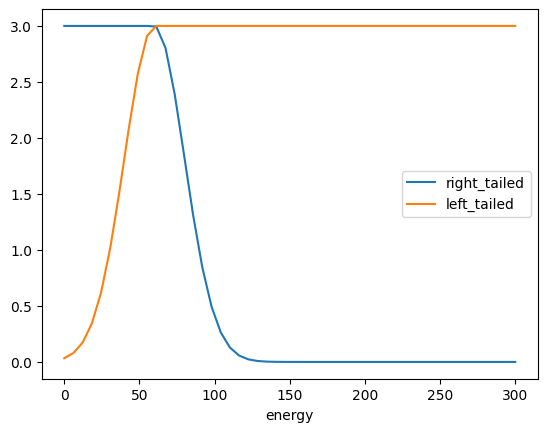

In [3]:
def right_tailed_exp(energy, val, m, v=20):
  if energy >= m:
    alpha = np.exp(-(energy - m)**2 / (v**2 * 2.0))
    val *= alpha
  return val

def left_tailed_exp(energy, val, m, v=20):
  if energy < m:
    alpha = np.exp(-(energy - m)**2 / (v**2 * 2.0))
    val *= alpha
  return val


energy = np.linspace(0, 300)
right_tailed = [right_tailed_exp(x, 3, 60) for x in energy]
left_tailed = [left_tailed_exp(x, 3, 60) for x in energy]

df = pd.DataFrame({'energy': energy, 'right_tailed': right_tailed, 'left_tailed': left_tailed})

df.set_index('energy').plot()

In [4]:
right_tailed_exp(90, 3, 60, v=15)

np.float64(0.4060058497098381)

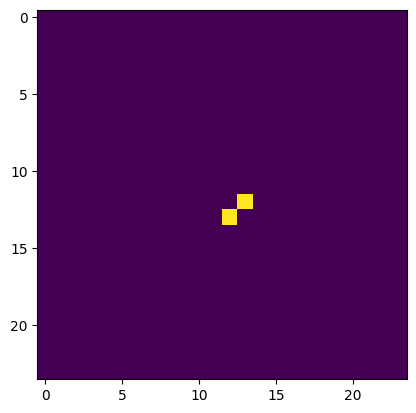

In [5]:
rows, cols = (24, 24)
x, y = np.ogrid[:rows, :cols]
pos = (12, 12)
enemy_dist = np.abs(x - pos[0]) + np.abs(y - pos[1])

init_pos = (23, 23)
enemy_init_pos_dist = 11 + 11
init_pos_dist = np.abs(x - init_pos[0]) + np.abs(y - init_pos[0])
mask = (enemy_dist == 1) & (init_pos_dist < enemy_init_pos_dist)


plt.imshow(mask)

In [6]:
np.minimum(np.array(range(5)), 2)

array([0, 1, 2, 2, 2])

# Optimizie

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

B = 4
N = 16
M = 230

logits = torch.randn(B, N, M)


one_hot_labels = torch.zeros(B, N, M)

random_indices = torch.randint(0, M, (B, N))

# Assign 1 to the corresponding positions
one_hot_labels[torch.arange(B).unsqueeze(1), torch.arange(N).unsqueeze(0), random_indices] = 1

true_labels = torch.argmax(one_hot_labels, dim=-1)


In [8]:
criterion = nn.CrossEntropyLoss()


# loss = criterion(logits, true_labels)

In [9]:
loss

NameError: name 'loss' is not defined

In [ ]:
logits.shape

In [ ]:
true_labels.shape

In [10]:
logits.shape

torch.Size([4, 16, 230])

# Energy node

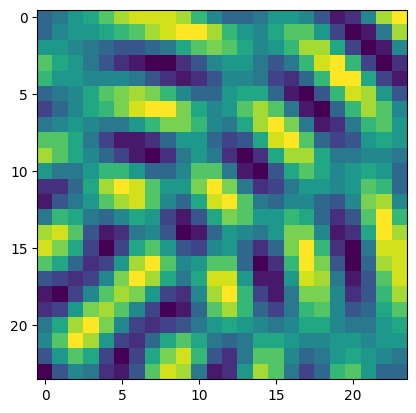

In [11]:
import chex
import jax
import jax.numpy as jnp
from jax import lax
from flax import struct
from luxai_s3.state import EnvState

ENERGY_NODE_FNS = [
    lambda d, x, y, z: jnp.sin(d * x + y) * z, lambda d, x, y, z: (x / (d + 1) + y) * z
]

energy_node_fns = jnp.array(
    [
        [0, 1.2, 1, 4],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        # [1, 4, 0, 2],
        [0, 1.2, 1, 4],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        # [1, 4, 0, 0]
    ]
)


MAP_WIDTH = 24
MAP_HEIGHT = 24


MAX_ENERGY_PER_TILE = 20
MIN_ENERGY_PER_TILE = -20

MAX_ENERGY_NODES = 6

@struct.dataclass
class EnvState2:
    energy_nodes: chex.Array
    energy_node_fns: chex.Array
    energy_nodes_mask: chex.Array



def compute_energy_features(state: EnvState):
    # first compute a array of shape (map_height, map_width, num_energy_nodes) with values equal to the distance of the tile to the energy node
    mm = jnp.meshgrid(jnp.arange(MAP_WIDTH), jnp.arange(MAP_HEIGHT))
    mm = jnp.stack([mm[0], mm[1]]).T.astype(jnp.int16)  # mm[x, y] gives [x, y]
    distances_to_nodes = jax.vmap(lambda pos: jnp.linalg.norm(mm - pos, axis=-1))(
        state.energy_nodes
    )

    def compute_energy_field(node_fn_spec, distances_to_node, mask):
        fn_i, x, y, z = node_fn_spec
        return jnp.where(
            mask,
            lax.switch(
                fn_i.astype(jnp.int16), ENERGY_NODE_FNS, distances_to_node, x, y, z
            ),
            jnp.zeros_like(distances_to_node),
        )

    energy_field = jax.vmap(compute_energy_field)(
        state.energy_node_fns, distances_to_nodes, state.energy_nodes_mask
    )
    # print(energy_field)
    energy_field = jnp.where(
        energy_field.mean() < 0.25,
        energy_field + (0.25 - energy_field.mean()),
        energy_field,
    )
    energy_field = jnp.round(energy_field.sum(0)).astype(jnp.int16)
    energy_field = jnp.clip(
        energy_field, MIN_ENERGY_PER_TILE, MAX_ENERGY_PER_TILE
    )
    return energy_field


energy_nodes_mask = jnp.zeros(shape=(MAX_ENERGY_NODES), dtype=jnp.bool)
energy_nodes_mask = energy_nodes_mask.at[:].set([True,  False, False,  True, False, False])

energy_nodes = jnp.array([[ 1, 15],
       [ 2, 15],
       [ 1, 12],
       [ 8, 22],
       [ 8, 21],
       [11, 22]], dtype=jnp.int16)


env_state = EnvState2(energy_node_fns=energy_node_fns,
          energy_nodes_mask=energy_nodes_mask,
          energy_nodes=energy_nodes)

energy_field = compute_energy_features(env_state)

plt.imshow(np.asarray(energy_field).T)

In [12]:
def anti_diag_sym_i(v):
  i, j = v
  if i == -1 or j == -1:
    return -1, -1
  return MAP_WIDTH - 1 - j, MAP_HEIGHT - 1 - i


def generate_manhattan_mask(shape, center, range_limit):
  rows, cols = shape
  x_center, y_center = center
  x, y = np.ogrid[:rows, :cols]
  manhattan_distance = np.abs(x - x_center) + np.abs(y - y_center)
  mask = manhattan_distance <= range_limit
  return mask

In [13]:
import numpy as np

target_energy_field = energy_field

positions = np.argwhere(generate_manhattan_mask((MAP_WIDTH, MAP_HEIGHT), (0, 0), MAP_WIDTH))
print(len(positions))

energy_nodes_mask_ = jnp.zeros(shape=(MAX_ENERGY_NODES), dtype=jnp.bool)
energy_nodes_mask_ = energy_nodes_mask.at[:].set([True,  False, False,  True, False, False])

for (x, y) in positions:
    xi, yi = anti_diag_sym_i((x, y))
    energy_nodes = jnp.array([(x, y),
       [0, 0],
       [0, 0],
       [xi, yi],
       [0, 0],
       [0, 0]], dtype=jnp.int16)

    env_state = EnvState2(energy_node_fns=energy_node_fns,
          energy_nodes_mask=energy_nodes_mask,
          energy_nodes=energy_nodes)

    test_energy_field = compute_energy_features(env_state)
    if (test_energy_field == target_energy_field).all():
        print(f'found {x, y}')


323
found (np.int64(1), np.int64(15))


In [14]:
energy_nodes_mask_.size

6

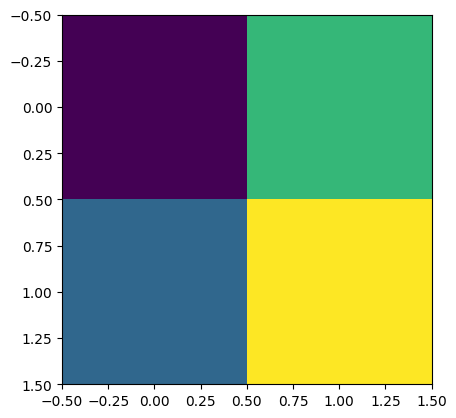

In [15]:
plt.imshow(np.asarray([[0, 1],[2, 3]]).T)

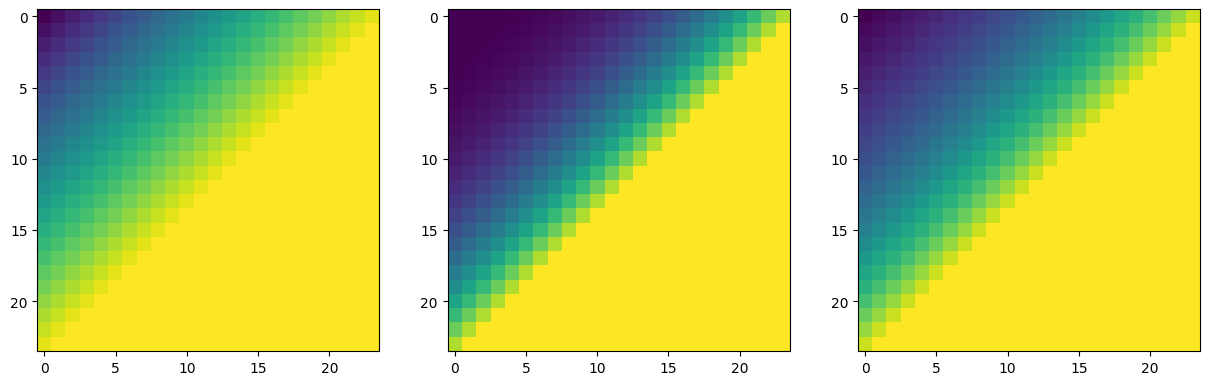

In [45]:
# manhanten dist matrix


def generate_manhattan_mask(shape, center):
  rows, cols = shape
  x_center, y_center = center
  x, y = np.ogrid[:rows, :cols]
  manhattan_distance = np.abs(x - x_center) + np.abs(y - y_center)
  return manhattan_distance


d1 = generate_manhattan_mask((24, 24), (0, 0))
d1[d1 > 24] = 24
d1 = d1.astype(np.float32)
d1 /= 24
d2 = d1 * d1 * d1


fig, axes = plt.subplots(1, 3, figsize=(15, 5)) 
axes[0].imshow(d1)
axes[1].imshow(d2)
axes[2].imshow(d1+d2 - 24)

In [46]:
d2.shape

(24, 24)

<Axes: >

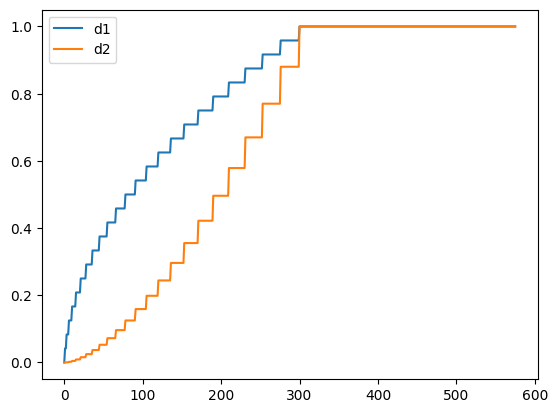

In [47]:
def flatten_then_sort(x):
    x = x.flatten()
    x.sort()
    return x
    
df = pd.DataFrame({'d1': flatten_then_sort(d1), 'd2': flatten_then_sort(d2)})

df.plot()